# Ноутбук для семинара `Трекинг экспериментов`

Сегодня мы:
- рассмотрим пайплайн подготовки данных и обучения модели классификации доходов
- создадим эксперимент в MLflow и настроим логирование:
    - параметров
    - метрик
    - моделей
    - артефактов
- проведём серию запусков с изменением параметров и сравним результаты в UI MLflow

## Импорты

In [1]:
# импорты для пайплайна

import numpy as np
from datasets import load_dataset
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder

/usr/local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [40]:
import mlflow
from mlflow.tracking import MlflowClient

In [277]:
mlflow.set_tracking_uri('http://158.160.203.250:5000/')

In [278]:
experiment = mlflow.set_experiment('adult-census-income')
experiment

<Experiment: artifact_location='mlflow-artifacts:/1', creation_time=1769619333417, experiment_id='1', last_update_time=1769619333417, lifecycle_stage='active', name='adult-census-income', tags={}>

In [51]:
client = MlflowClient()

In [239]:
run = client.create_run(experiment_id=1)
run

<Run: data=<RunData: metrics={}, params={}, tags={'mlflow.runName': 'wistful-mule-293'}>, info=<RunInfo: artifact_uri='mlflow-artifacts:/1/3f1fc39ea313439eb10ea704ce620fa8/artifacts', end_time=None, experiment_id='1', lifecycle_stage='active', run_id='3f1fc39ea313439eb10ea704ce620fa8', run_name='wistful-mule-293', run_uuid='3f1fc39ea313439eb10ea704ce620fa8', start_time=1769622037874, status='RUNNING', user_id='unknown'>, inputs=<RunInputs: dataset_inputs=[]>>

In [33]:
# with mlflow.start_run():
#     mlflow.log_param('dataset_size', 1000)
#     mlflow.log_metric('ROC-AUC', 0.999)
#     mlflow.log_artifact('/app/README.md')
#     mlflow.sklearn.log_model(model, 'model')

2026/01/28 17:02:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run hilarious-donkey-859 at: http://158.160.203.250:5000/#/experiments/1/runs/5e61e139cd164f80b3924982f9a7dd9a
🧪 View experiment at: http://158.160.203.250:5000/#/experiments/1


### Константы

In [139]:
DATASET_NAME = 'scikit-learn/adult-census-income'
TEST_SIZE = 0.3
RANDOM_STATE = 42

## Скачивание и подготовка данных

Скачаем данные

In [3]:
dataset = load_dataset(DATASET_NAME)

Посмотрим на них и изучим

In [54]:
dataset

DatasetDict({
    train: Dataset({
        features: ['age', 'workclass', 'fnlwgt', 'education', 'education.num', 'marital.status', 'occupation', 'relationship', 'race', 'sex', 'capital.gain', 'capital.loss', 'hours.per.week', 'native.country', 'income'],
        num_rows: 32561
    })
})

In [5]:
dataset['train'].features

{'age': Value(dtype='int64', id=None),
 'workclass': Value(dtype='string', id=None),
 'fnlwgt': Value(dtype='int64', id=None),
 'education': Value(dtype='string', id=None),
 'education.num': Value(dtype='int64', id=None),
 'marital.status': Value(dtype='string', id=None),
 'occupation': Value(dtype='string', id=None),
 'relationship': Value(dtype='string', id=None),
 'race': Value(dtype='string', id=None),
 'sex': Value(dtype='string', id=None),
 'capital.gain': Value(dtype='int64', id=None),
 'capital.loss': Value(dtype='int64', id=None),
 'hours.per.week': Value(dtype='int64', id=None),
 'native.country': Value(dtype='string', id=None),
 'income': Value(dtype='string', id=None)}

In [6]:
df = dataset['train'].to_pandas()
df

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,22,Private,310152,Some-college,10,Never-married,Protective-serv,Not-in-family,White,Male,0,0,40,United-States,<=50K
32557,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32558,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32559,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K


Описание признаков:

- `age` &mdash; возраст человека
- `workclass` &mdash; тип занятости
- `fnlwgt` &mdash; вес наблюдения в данных переписи населения США (сколько реальных людей в популяции «представляет» эта строка)
- `education` &mdash; образование
- `education.num` &mdash; уровень образования в виде числа
- `marital.status` &mdash; семейное положение
- `occupation` &mdash; профессия / род деятельности
- `relationship` &mdash; роль человека в семье
- `race` &mdash; расовая группа
- `sex` &mdash; пол человека (`Male` / `Female`)
- `capital.gain` &mdash; доход от капитала (прибыль от продажи активов)
- `capital.loss` &mdash; убытки от капитала
- `hours.per.week` &mdash; количество рабочих часов в неделю
- `native.country` &mdash; страна происхождения

Описание таргета:

- `income` &mdash; бинарно, получает человек больше 50k $ в год или нет

Оставим только часть признаков

In [234]:
columns = [
    'race', 'sex', 'native.country', 'occupation', 'education', 'capital.gain'
]

target_column = 'income'

И разделим датафрейм на признаки и таргет

In [235]:
X, y = df[columns], df[target_column]

In [240]:
X.drop_duplicates()

,race,sex,native.country,occupation,education,capital.gain
0,White,Female,United-States,?,HS-grad,0
1,White,Female,United-States,Exec-managerial,HS-grad,0
2,Black,Female,United-States,?,Some-college,0
3,White,Female,United-States,Machine-op-inspct,7th-8th,0
4,White,Female,United-States,Prof-specialty,Some-college,0
...,...,...,...,...,...,...
32513,Black,Female,Dominican-Republic,Other-service,10th,0
32534,Asian-Pac-Islander,Female,United-States,?,Bachelors,0
32546,Other,Female,United-States,Other-service,Masters,0
32552,Amer-Indian-Eskimo,Male,United-States,Handlers-cleaners,10th,0


In [241]:
mlflow.log_params({'features': str(X.columns.tolist())}, run_id=run.info.run_id)

In [242]:
y

0        <=50K
1        <=50K
2        <=50K
3        <=50K
4        <=50K
         ...  
32556    <=50K
32557    <=50K
32558     >50K
32559    <=50K
32560    <=50K
Name: income, Length: 32561, dtype: object

Используем Label Encoding для кодирования категориальных признаков

In [243]:
# cat_features = ['workclass', 'occupation', 'marital.status', 'sex']
# num_features = list(set(columns) - set(cat_features))
cat_features = ['race', 'sex', 'native.country', 'education', 'occupation']
num_features = list(set(columns) - set(cat_features))

In [244]:
preprocessor = OrdinalEncoder()

In [254]:
X_transformed = np.hstack([X[num_features], preprocessor.fit_transform(X[cat_features])])
# X_transformed = preprocessor.fit_transform(X[cat_features])

In [255]:
X_transformed

array([[ 0.,  4.,  0., 39., 11.,  0.],
       [ 0.,  4.,  0., 39., 11.,  4.],
       [ 0.,  2.,  0., 39., 15.,  0.],
       ...,
       [ 0.,  4.,  1., 39., 11.,  7.],
       [ 0.,  4.,  0., 39., 11.,  1.],
       [ 0.,  4.,  1., 39., 11.,  1.]])

In [256]:
X_transformed.shape

(32561, 6)

И закодируем целевую переменную

In [257]:
y_transformed = (y == '>50K').astype(int)

In [258]:
y_transformed

0        0
1        0
2        0
3        0
4        0
        ..
32556    0
32557    0
32558    1
32559    0
32560    0
Name: income, Length: 32561, dtype: int64

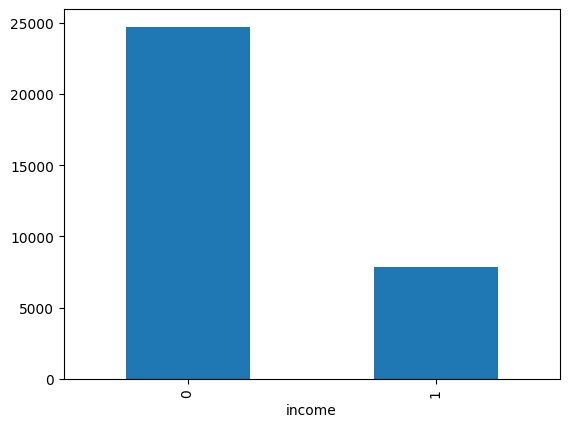

In [259]:
y_transformed.value_counts().plot.bar();

Разделим на train и test

In [260]:
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y_transformed, test_size=TEST_SIZE)

In [261]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((22792, 6), (9769, 6), (22792,), (9769,))

In [253]:
mlflow.log_params({'train_size': len(X)}, run_id=run.info.run_id)

## Обучение модели

В качестве бейзлайна возьмём логистическую регрессию

In [262]:
model_params = dict(penalty='l2', C=0.9, solver='lbfgs', max_iter=5000, random_state=RANDOM_STATE)

In [263]:
model = LogisticRegression(**model_params)
model

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'l2'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",0.9
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",42
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`multiclass` p

И запустим её обучение

In [264]:
model.fit(X_train, y_train)
model

/usr/local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(


,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'l2'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",0.9
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",42
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`multiclass` p

In [265]:
mlflow.log_params(model_params, run_id=run.info.run_id)

In [266]:
with mlflow.start_run(run_id=run.info.run_id):
    mlflow.sklearn.log_model(model, 'model')

2026/01/28 17:41:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run wistful-mule-293 at: http://158.160.203.250:5000/#/experiments/1/runs/3f1fc39ea313439eb10ea704ce620fa8
🧪 View experiment at: http://158.160.203.250:5000/#/experiments/1


## Оценка качества модели

Получим предсказания на тесте обученной модели

In [267]:
y_proba = model.predict_proba(X_test)[:, 1]

In [268]:
y_proba.shape

(9769,)

In [270]:
y_pred = np.where(y_proba >= 0.5, 1, 0)

In [269]:
max(y_proba)

np.float64(0.9999999999999971)

Считаем метрики

In [271]:
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)

In [272]:
print(f"Accuracy: {accuracy:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")

Accuracy: 0.8015
F1-score: 0.3375
ROC-AUC: 0.7207


In [273]:
mlflow.log_metrics({'Accuracy': accuracy, 'F1': f1, 'ROC-AUC': roc_auc}, run_id=run.info.run_id)

In [274]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, digits=6))

              precision    recall  f1-score   support

           0   0.801398  0.983774  0.883270      7457
           1   0.803252  0.213668  0.337547      2312

    accuracy                       0.801515      9769
   macro avg   0.802325  0.598721  0.610409      9769
weighted avg   0.801837  0.801515  0.754115      9769

